In [74]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [75]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows=10000)

In [76]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows=10000)

In [77]:
Train_nor, Test_nor = train_test_split(Nor_df, test_size=0.3, random_state=1)
Train_abnor, Test_abnor = train_test_split(Abnor_df, test_size=0.3, random_state=1) 

Train = pd.concat([Train_nor, Train_abnor], ignore_index=True)

Test = pd.concat([Test_nor, Test_abnor], ignore_index=True)

In [6]:
def nomial(dataset1, dataset2):
    protocol1 = dataset1['protocol_type'].copy()
    protocol2 = dataset2['protocol_type'].copy()
    protocol_type = ["tcp", "udp", "icmp"]
    for i in range(len(protocol_type)):
        protocol1[protocol1 == protocol_type[i]] = i
        protocol2[protocol2 == protocol_type[i]] = i
    dataset1['protocol_type'] = protocol1
    dataset2['protocol_type'] = protocol2

    service1 = dataset1['service'].copy()
    service2 = dataset2['service'].copy()
    service_type = ["other", "private", "ecr_i", "urp_i", "urh_i", "red_i", "eco_i", "tim_i", "oth_i", "domain_u", "tftp_u", "ntp_u", "IRC", 
                "X11", "Z39_50", "aol", "auth", "bgp", "courier", "csnet_ns", "ctf", "daytime", "discard", "domain", "echo", "efs", "exec", 
                "finger", "ftp", "ftp_data", "gopher", "harvest", "hostnames", "http", "http_2784", "http_443", "http_8001", "icmp", "imap4",
                "iso_tsap", "klogin", "kshell", "ldap", "link", "login", "mtp", "name", "netbios_dgm", "netbios_ns", "netbios_ssn", "netstat",
                "nnsp", "nntp", "pm_dump", "pop_2", "pop_3", "printer", "remote_job", "rje", "shell", "smtp", "sql_net", "ssh", "sunrpc", 
                "supdup", "systat", "telnet", "time", "uucp", "uucp_path", "vmnet", "whois"]
    for i in range(len(service_type)):
        service1[service1 == service_type[i]] = i
        service2[service2 == service_type[i]] = i
    dataset1['service'] = service1
    dataset2['service'] = service2

    flag1 = dataset1['flag'].copy()
    flag2 = dataset2['flag'].copy()
    flag_type = ["SF", "S0", "S1", "S2", "S3", "REJ", "RSTOS0", "RSTO", "RSTR", "SH", "RSTRH", "SHR", "OTH"]
    for i in range(len(flag_type)):
        flag1[flag1 == flag_type[i]] = i
        flag2[flag2 == flag_type[i]] = i
    dataset1['flag'] = flag1
    dataset2['flag'] = flag2

In [7]:
def scaler(dataset):
    # num_features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    #             "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
    #             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
    #             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    #             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    #             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    #             "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
    # ]
    # Duration:
    duration = dataset["duration"].copy()
    dataset["duration"] = duration / 2                              # Max duration in a window frame capture

    # Protocol type:
    protocol_type = dataset["protocol_type"].copy()
    dataset["protocol_type"] = protocol_type / 2                    # 3 protocol types

    # Service
    service = dataset["service"].copy()
    dataset["service"] = service / 71                               # 72 service types

    # Flag
    flag = dataset["flag"].copy()
    dataset["flag"] = flag / 12                                     # 13 flag types

    # Src bytes
    src_bytes = dataset["src_bytes"].copy()
    dataset["src_bytes"] = src_bytes / 65535                        # 2^16 bytes - Max size per TCP packet

    # Dst bytes
    dst_bytes = dataset["dst_bytes"].copy()
    dataset["dst_bytes"] = dst_bytes / 65535                        # 2^16 bytes - Max size per TCP packet

    # Count
    count = dataset["count"].copy()
    dataset["count"] = count / 5000                                 # 2s / minimum time-slot of ACK packets

    # Srv_count
    srv_count = dataset["srv_count"].copy()
    dataset["srv_count"] = srv_count / 5000                         # 2s / minimum time-slot of ACK packets

    # Dst_host_count
    dst_host_count = dataset["dst_host_count"].copy()
    dataset["dst_host_count"] = dst_host_count / 5000               # 2s / minimum time-slot of ACK packets

    # Dst_host_srv_count
    dst_host_srv_count = dataset["dst_host_srv_count"].copy()
    dataset["dst_host_srv_count"] = dst_host_srv_count / 5000       # 2s / minimum time-slot of ACK packets

In [11]:
num_features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
    ]      
nomial(Train_nor,Train_abnor)
nomial(Test_nor,Test_abnor)
Train_nor[num_features] = Train_nor[num_features].astype(float)
scaler(Train_nor)
Train_abnor[num_features] = Train_abnor[num_features].astype(float)
scaler(Train_abnor)
Train_nor = Train_nor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","label"])
Train_abnor = Train_abnor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","label"])
Test_nor[num_features] = Test_nor[num_features].astype(float)
scaler(Test_nor)
Test_abnor[num_features] = Test_abnor[num_features].astype(float)
scaler(Test_abnor)
Test_nor = Test_nor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","label"])
Test_abnor = Test_abnor.drop(columns=["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","label"])

In [78]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [79]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [80]:
# xử lý dữ liệu
train = preprocess(Train, True)
test = preprocess(Test, False)

In [81]:
train['data'].shape, test['data'].shape

((14000, 50), (6000, 50))

In [82]:
# chia dữ liệu
Train_nor = train['data'][train['label'] == 'Normal']
Train_abnor = train['data'][train['label'] == 'Abnormal']

Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

In [11]:
print(Train_nor.shape)
print(Train_abnor.shape)

(7000, 50)
(7000, 50)


In [85]:
Train_nor.shape[1]

50

# cGAN Test 

In [86]:
from keras import layers, Model, Sequential
import matplotlib.pyplot as plt

# Hàm tạo Generator
def build_generator(noise_dim, data_dim):
    model = Sequential()
    model.add(layers.Dense(256, input_dim=noise_dim, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(data_dim, activation='sigmoid'))
    return model

# Hàm tạo Discriminator
def build_discriminator(data_dim):
    model = Sequential()
    model.add(layers.Dense(512, input_dim=data_dim, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Hàm tạo cGAN
def build_cgan(generator, discriminator):
    noise = layers.Input(shape=(noise_dim,))
    generated_data = generator(noise)
    cgan_output = discriminator(generated_data)

    cgan = Model(noise, cgan_output)
    return cgan

# Kích thước của vector nhiễu đầu vào cho Generator
noise_dim = 100

# Xây dựng Generator và Discriminator
data_dim = Train_nor.shape[1]
generator = build_generator(noise_dim, data_dim)
discriminator = build_discriminator(data_dim)

# Hàm mất mát và tối ưu hóa cho Generator và Discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output,valid_labels):
    return cross_entropy(valid_labels, fake_output)

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Biên dịch mô hình cGAN
generator.compile(optimizer=generator_optimizer, loss=generator_loss, metrics=['accuracy'])
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss, metrics=['accuracy'])
cgan = build_cgan(generator, discriminator)
cgan.compile(optimizer=generator_optimizer, loss=generator_loss, metrics=['accuracy'])

# Hàm huấn luyện cGAN
def train_cgan(generator, discriminator, cgan, Train_nor, epochs, batch_size):
    num_batches = Train_nor.shape[0] // batch_size
    for epoch in range(epochs):
        for batch_idx in range(num_batches):
            # Huấn luyện Discriminator
            noise = tf.random.normal([batch_size, noise_dim])
            generated_data = generator.predict(noise)

            #real_data = Train_nor.iloc[batch_idx * batch_size:(batch_idx + 1) * batch_size].values
            real_data = Train_nor[np.random.randint(0, Train_nor.shape[0], batch_size), :]

            real_data_labels = np.ones((batch_size, 1))
            fake_data_labels = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_data, real_data_labels)
            d_loss_fake = discriminator.train_on_batch(generated_data, fake_data_labels)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Huấn luyện Generator
            noise = tf.random.normal([batch_size, noise_dim])
            valid_labels = np.ones((batch_size, 1))

            g_loss = cgan.train_on_batch(noise, valid_labels)
            print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

# Thiết lập thông số huấn luyện
epochs = 128
batch_size = 64

# Huấn luyện cGAN
train_cgan(generator, discriminator, cgan, Train_nor, epochs, batch_size)

# Sử dụng Generator để tạo dữ liệu giả
num_fake_samples = 1000
noise = tf.random.normal([num_fake_samples, noise_dim])
generated_data = generator.predict(noise)

# Đánh giá hiệu suất của mô hình
# ... (So sánh dữ liệu giả và dữ liệu thật từ `Train_nor` để phát hiện bất thường)


2/2 [==============================] - 0s 8ms/step


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0, Discriminator Loss: [1.14782164 0.5546875 ], Generator Loss: [0.8907674551010132, 0.0]
2/2 [==============================] - 0s 7ms/step
Epoch 0, Discriminator Loss: [1.11061957 0.53125   ], Generator Loss: [0.9080027937889099, 0.0]
2/2 [==============================] - 0s 8ms/step
Epoch 0, Discriminator Loss: [1.07669863 0.5       ], Generator Loss: [0.9255250692367554, 0.0]
2/2 [==============================] - 0s 8ms/step
Epoch 0, Discriminator Loss: [1.0474647 0.5      ], Generator Loss: [0.9426996111869812, 0.0]
2/2 [==============================] - 0s 7ms/step
Epoch 0, Discriminator Loss: [1.01550487 0.5       ], Generator Loss: [0.9589320421218872, 0.0]
2/2 [==============================] - 0s 9ms/step
Epoch 0, Discriminator Loss: [0.98873287 0.5       ], Generator Loss: [0.9729006290435791, 0.0]
2/2 [==============================] - 0s 7ms/step
Epoch 0, Discriminator Loss: [0.96126366 0.5       ], Generator Loss: [0.9895482659339905, 0.0]
2/2 [===================

In [87]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [88]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [89]:
model.fit(Train_nor, Train_nor, batch_size=64, epochs=200, shuffle=True)

Epoch 1/200
110/110 [==============================] - 3s 12ms/step - loss: 0.2109
Epoch 2/200
110/110 [==============================] - 1s 13ms/step - loss: 0.1467
Epoch 3/200
110/110 [==============================] - 1s 13ms/step - loss: 0.0931
Epoch 4/200
110/110 [==============================] - 1s 13ms/step - loss: 0.0690
Epoch 5/200
110/110 [==============================] - 1s 11ms/step - loss: 0.0599
Epoch 6/200
110/110 [==============================] - 1s 11ms/step - loss: 0.0561
Epoch 7/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0541
Epoch 8/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0530
Epoch 9/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0520
Epoch 10/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0501
Epoch 11/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0482
Epoch 12/200
110/110 [==============================] - 1s 12ms/step - loss: 0.0456
E

In [93]:

# Sử dụng Generator để tạo dữ liệu giả
num_fake_samples = 1000
noise = tf.random.normal([num_fake_samples, noise_dim])
generated_data = generator.predict(noise)

# Chuyển đổi dữ liệu thật từ DataFrame thành numpy array
real_data = Train_nor
generated_data


32/32 [==============================] - 1s 18ms/step


array([[7.6940677e-07, 3.7470952e-06, 8.8369359e-07, ..., 1.2609980e-06,
        2.0531546e-05, 2.0058549e-06],
       [1.4266784e-06, 1.2754578e-05, 2.3995008e-06, ..., 4.7077879e-06,
        2.4684199e-05, 6.8715503e-06],
       [4.2605507e-06, 1.9991168e-05, 1.1747760e-05, ..., 6.8212953e-06,
        5.8330250e-05, 4.2652828e-06],
       ...,
       [1.6703783e-06, 5.2561927e-06, 8.2777211e-07, ..., 4.6985078e-06,
        1.0278417e-04, 3.7895111e-06],
       [4.5550842e-06, 1.8732051e-05, 4.4530811e-06, ..., 6.4240903e-06,
        6.3790503e-05, 4.3233704e-06],
       [3.4742229e-07, 8.8891630e-07, 9.2058605e-07, ..., 3.4417727e-07,
        3.0073654e-06, 3.9609608e-07]], dtype=float32)

In [94]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)
test_normal_re

94/94 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(3000,), dtype=float32, numpy=
array([7.0839662e-05, 8.3135332e-05, 2.4891776e-04, ..., 2.1838809e-03,
       8.8806683e-04, 3.6956009e-04], dtype=float32)>

In [95]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.02219298668205738


32/32 [==============================] - 0s 3ms/step


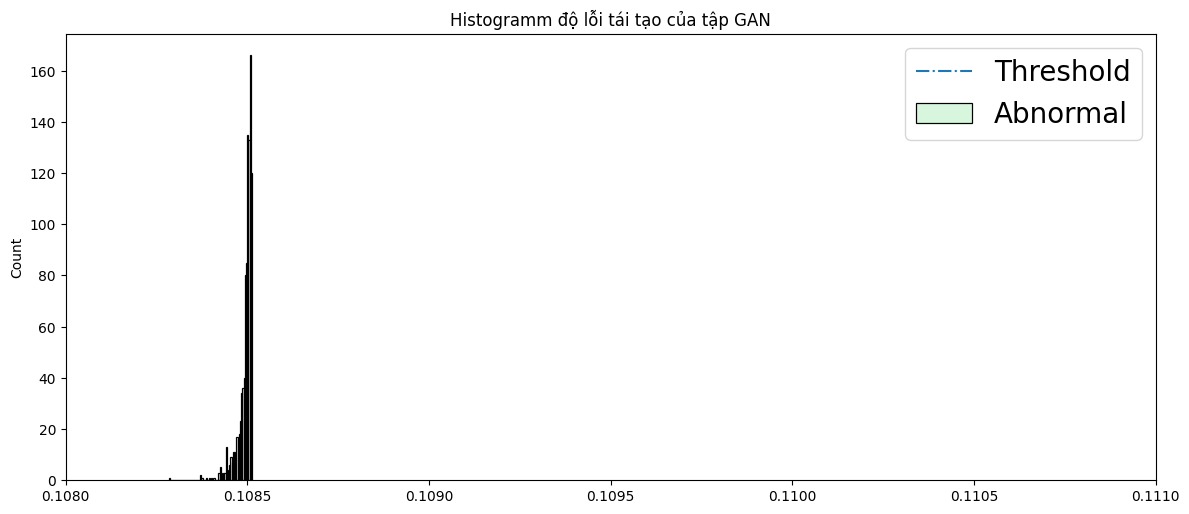

In [111]:
GAN_abnormal_re = model.get_reconstruction_error(generated_data)

fig, ax = plt.subplots(figsize=(12, 5))
#sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=GAN_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0.108,0.111])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập GAN')
plt.show()

In [112]:
test_normal_re

<tf.Tensor: shape=(3000,), dtype=float32, numpy=
array([7.0839662e-05, 8.3135332e-05, 2.4891776e-04, ..., 2.1838809e-03,
       8.8806683e-04, 3.6956009e-04], dtype=float32)>